In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import os
Root = "/content/drive/MyDrive/brain_tumor/brain_tumor_dataset"
os.chdir(Root)

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [ ]:
data = '/content/drive/MyDrive/brain_tumor/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/brain_tumor/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/brain_tumor/brain_tumor_dataset/yes'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [ ]:
Files=pd.Series(filepaths, name='filepaths') 
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/brain_tumor/brain_tumor...,No
1,/content/drive/MyDrive/brain_tumor/brain_tumor...,No
2,/content/drive/MyDrive/brain_tumor/brain_tumor...,No
3,/content/drive/MyDrive/brain_tumor/brain_tumor...,No
4,/content/drive/MyDrive/brain_tumor/brain_tumor...,No


In [ ]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


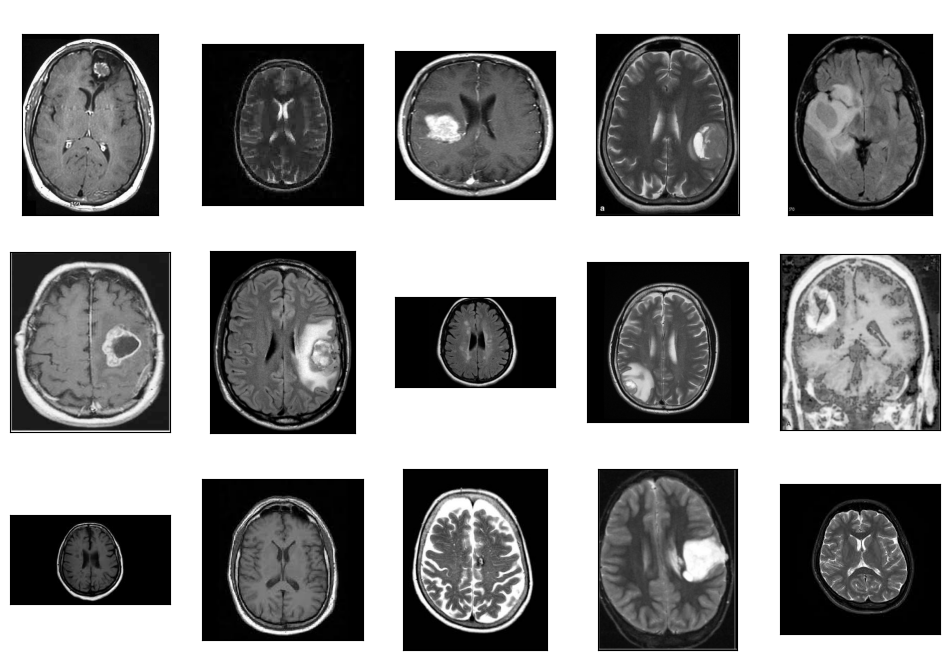

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
___________________________________________

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
7/7 [==============================] - 54s 7s/step - loss: 0.7304 - accuracy: 0.5417 - val_loss: 0.6711 - val_accuracy: 0.7083
Epoch 2/10
7/7 [==============================] - 42s 6s/step - loss: 0.6930 - accuracy: 0.5972 - val_loss: 0.5708 - val_accuracy: 0.6667
Epoch 3/10
7/7 [==============================] - 42s 6s/step - loss: 0.6275 - accuracy: 0.6620 - val_loss: 0.7213 - val_accuracy: 0.5417
Epoch 4/10
7/7 [==============================] - 37s 5s/step - loss: 0.6274 - accuracy: 0.6620 - val_loss: 0.5795 - val_accuracy: 0.7083
Epoch 5/10
7/7 [==============================] - 45s 7s/step - loss: 0.6697 - accuracy: 0.6111 - val_loss: 0.5461 - val_accuracy: 0.6667
Epoch 6/10
7/7 [==============================] - 42s 6s/step - loss: 0.6662 - accuracy: 0.6713 - val_loss: 0.6466 - val_accuracy: 0.6667
Epoch 7/10
7/7 [==============================] - 41s 6s/step - loss: 0.6157 - accuracy: 0.6667 - val_loss: 0.6131 - val_accuracy: 0.6250
Epoch 8/10
7/7 [==================

In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebook/Brain_Tumor_Detection/Tumor_classifier_model.h5")

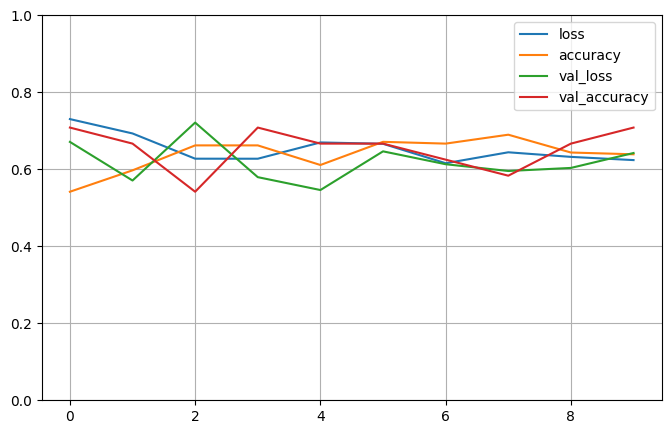

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/brain_tumor/brain_tumor_dataset/no/1 no.jpeg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >=0.5:
  print("YES")
else:
  print("No")

1/1 [==============================] - 1s 1s/step
No


In [ ]:
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# Load the test dataset
test_path = "/content/drive/MyDrive/brain_tumor/brain_tumor_dataset"
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32
)

# Make predictions on the test dataset
y_pred = loaded_model.predict(test_data)

# Convert predicted probabilities to class labels
y_pred = np.round(y_pred).astype(int)

# Extract true labels from the test dataset
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true = y_true.astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Found 253 files belonging to 2 classes.
8/8 [==============================] - 39s 5s/step
Accuracy: 0.6126482213438735


In [ ]:
import cv2
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
X = []
y = []

for image_path in os.listdir(Yes_brain_tumor):
    img = cv2.imread(os.path.join(Yes_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(1)
    
for image_path in os.listdir(No_brain_tumor):
    img = cv2.imread(os.path.join(No_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(0)

# Convert the data to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = knn.predict(X_test)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print('KNN Accuracy:', accuracy)
##KNN

KNN Accuracy: 0.6470588235294118


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from PIL import Image
X = []
y = []

for image_path in os.listdir(Yes_brain_tumor):
    img = cv2.imread(os.path.join(Yes_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(1)
    
for image_path in os.listdir(No_brain_tumor):
    img = cv2.imread(os.path.join(No_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(0)

# Convert the data to NumPy arrays
X = np.array(X)
y = np.array(y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

image = cv2.imread("/content/drive/MyDrive/brain_tumor/brain_tumor_dataset/no/1 no.jpeg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
input_data = np.array(resize_image)
input_data = input_data.reshape(1, 224*224*3)

# Make a prediction on the sample image
prediction = rf.predict(input_data)

if prediction == 1:
  print("YES")
else:
  print("No")

Random Forest Accuracy: 0.803921568627451
No


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from PIL import Image
X = []
y = []

for image_path in os.listdir(Yes_brain_tumor):
    img = cv2.imread(os.path.join(Yes_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(1)
    
for image_path in os.listdir(No_brain_tumor):
    img = cv2.imread(os.path.join(No_brain_tumor, image_path))
    img = cv2.resize(img, (224, 224))
    X.append(img.flatten())
    y.append(0)

# Convert the data to NumPy arrays
X = np.array(X)
y = np.array(y)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = DecisionTreeClassifier(criterion='entropy',random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", accuracy)

image = cv2.imread("/content/drive/MyDrive/brain_tumor/brain_tumor_dataset/no/1 no.jpeg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
input_data = np.array(resize_image)
input_data = input_data.reshape(1, 224*224*3)

# Make a prediction on the sample image
prediction = rf.predict(input_data)

if prediction == 1:
  print("YES")
else:
  print("No")

Decision Tree Accuracy: 0.7450980392156863
No
